<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>

<font color='blue'>
<br />
Мария, доброго дня! рад приветствовать тебя. <br />
<br />    

<br />
Меня зовут Николай Шавлюго. <br />И на этом этапе твоего движения к новой профессии от меня будут комментарии по написанному коду. <br />Чтобы меньше "мусорить эфир" и чтобы максимально наглядно отделяться от основного кода, есть предложение условиться в некоторых обозначениях:<br /> <br />
<u><b>ТАКОЙ ШРИФТ</b></u> - всегда начало комментария <br />
<font color='green'>такой шрифт</font> - комментарии о том, что всё ОК <br/>
<font color='orange'>такой шрифт</font> - комментарии о том, что всё ОК по результату,<br> однако есть на что обратить внимание в плане применения техник, или есть способы сделать более короткий или быстрый код <br/>
<font color='red'>такой шрифт</font> - комментарии о том, что есть критичный момент, влияющий на бизнес-результат проекта.<br/>
</font><br /><br />
<font color='green'>Моей целью является не "уличить" в не знании, а просто высказать сверху твоих знаний - свой опыт, что бы ты мог использовать его для своего дальнейшего успеха) И очень здорово будет, если тебе удастся задавать вопросы, да и вообще - всячески доставать меня, если я по каким-то причинам не приму проект:) При этом, из своего опыта скажу, хорошо и важно, когда переписка ревьюера и студента - сохраняется на следующие проекты и даже на будущую практическую деятельность.<br>
<br> Я сразу же начал общаться на ты:) но если это не очень удобно, то дай знать)) <BR> В ПУТЬ!<br>

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import os

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from collections import defaultdict

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool
from sklearn import linear_model

from joblib import dump, load

import matplotlib.pyplot as plt

rnd_state = 12345
data  = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col=['datetime'])

In [2]:
data = data.sort_index() 

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
data.shape

(26496, 1)

In [6]:
data.index.min(), data.index.max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:50:00'))

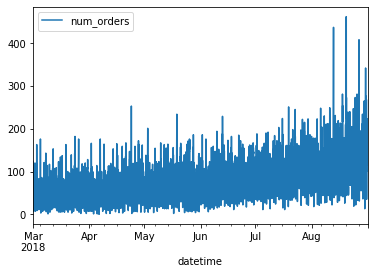

In [7]:
data = data.resample('1H').sum()
data.plot()

#### Выводы: 
- импортировали и открыли данные 
- посмотрели наименьший и наибольший индекс 
- осуществили ресемплирование по одному часу

Наблюдается повышенное количество заказов в летнее время, преимущественно в августе. Возможно, потому что август считается наиболее популярным месяцем для отпуска. 

<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'>
ОК, данные на базе)

# 2. Анализ

Выполним декомпозицию и посмотим на тренды и сезонность.

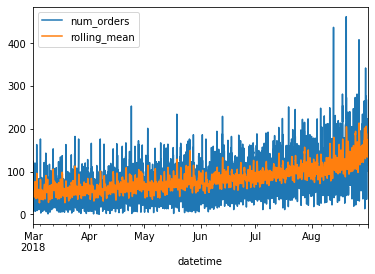

In [8]:
data['rolling_mean'] = data.rolling(10).mean()
data.plot()

Проверим данные на пропуски, которые в дальнейшем удалим.

In [9]:
data.isnull().sum()

num_orders      0
rolling_mean    9
dtype: int64

In [10]:
data['rolling_mean'] = data['rolling_mean'].fillna(0)

In [11]:
decomposed_data = seasonal_decompose(data)

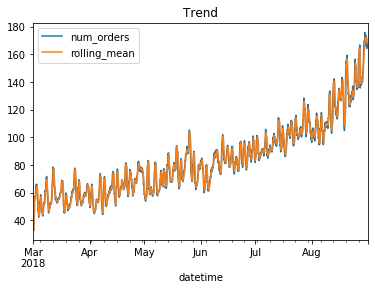

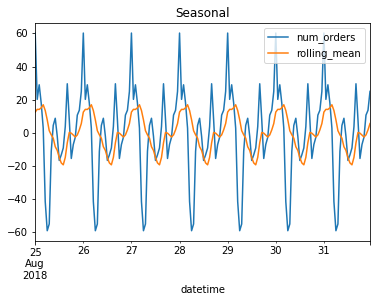

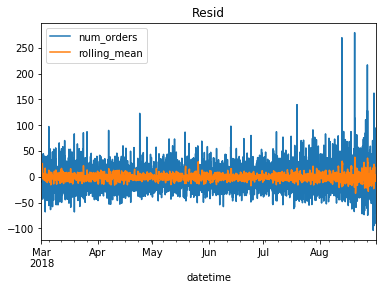

In [12]:
decomposed_data = seasonal_decompose(data)
decomposed_data.trend.plot(title='Trend')
decomposed_data.seasonal.tail(24*7).plot(title='Seasonal')
decomposed_data.resid.plot(title='Resid')

Мы видим, что наиболее активным месяцем является август. Рассмотрим его подробнее:

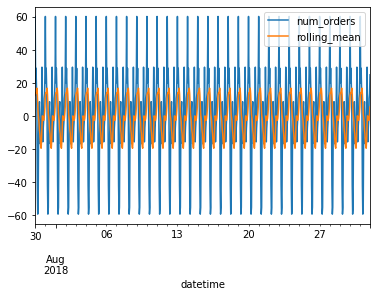

In [13]:
decomposed_data.seasonal['2018-07-30':'2018-08-31'].plot(ax=plt.gca())

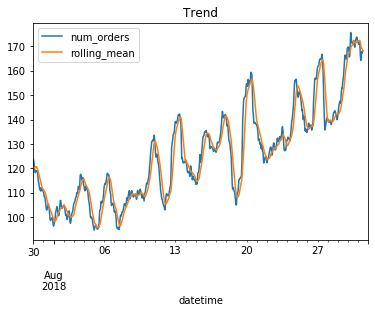

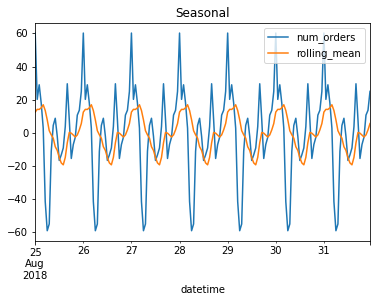

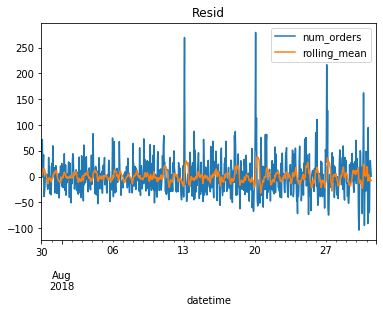

In [14]:
decomposed_data.trend['2018-07-30':'2018-08-31'].plot(title='Trend')
decomposed_data.seasonal['2018-07-30':'2018-08-31'].tail(24*7).plot(title='Seasonal')
decomposed_data.resid['2018-07-30':'2018-08-31'].plot(title='Resid')

#### Вывод: 

Исходя из анализа данных можно отметить дневную сезонность, восходящий тренд в августе. Наиболее пиковым месяцем мы видим август, дневное время.

<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'>
Исследование - понятно, хорошо, что глянули график на коротком периоде<br>
Инструмент декомпозиции в частности, а графический анализ временных рядов как в принципе - очень нужный этап моделирования рядов.<br> Позволяет увидеть продажи визуально, а это очень помогает сделать предвариетльные выводы<br>
    
Хочу озвучить ещё такой момент<br>
Дело в том, в реальности бизнеса есть все три вида сезонности:<br>
1)дневная сезонность есть - ведь данные собраны по дням, т.е. будни и выходные имеют разные продажи<br>
2)Но ведь есть ещё внутрисуточная сезонность: когда продажи утром отличаются от продаж вечером (об этом Вы сказали) <br>
3)Ну и наконец есть месячная сезонность: когда продажи лета и осени - разные.<br><br>
И если строить прогноз на длительный период времени, то без учёта всех видов сезонности  - не обойтись<br>
Например: есть в данных (и Вы об этом пишите) восходящий тренд. Но вопрос такой возникает: <br>
этот подъём действительно за счёт роста компании (чаще всего тренд - это отражение роста компании) или есть ещё влияние месячной сезнности? (летом - продаж в рост, например, и именно этот момент мы наблюдаем в данных)<br>
Ответ на вопрос - не протой на имеющихся данных - у нас данных меньше года. А это означает, что месячную сезонность нам не просто вычислить адекватно - т.е. не внести в модель корректтировки месяцев(<br>
Поэтому, я бы дал такой совет:<br>
на горизонте прогнозирования - несколько часов или дней - можно предположить что у нас тренд.<br>
А если строить прогноз на несколько недель - вот тут утверждать наличие тренда надо с большой осторожностью))))<br><br>
Ну, а если вернуться к постановке задаче - построить прогноз на час (очень маленький горизонт), то двух сезонности может и хватить.

# 3. Обучение

Разбиваем датасет на обучающую и тестовую выборки. Для тестовой выборки нам необходимо 10% от исходных данных. Разделяем данные на обычные и целевые признаки.

In [29]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for l in range(max_lag):
        data['lag_'+str(l)] = data['num_orders'].shift(l+1)
            
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()        

In [36]:
make_features(data, 4, 4)
data.head()

,num_orders,rolling_mean,dayofweek,hour,lag_0,lag_1,lag_2,lag_3
datetime,,,,,,,,
2018-03-01 00:00:00,124,NaN,3,0,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,3,1,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,3,2,85.0,124.0,NaN,NaN
2018-03-01 03:00:00,66,NaN,3,3,71.0,85.0,124.0,NaN
2018-03-01 04:00:00,43,86.5,3,4,66.0,71.0,85.0,124.0


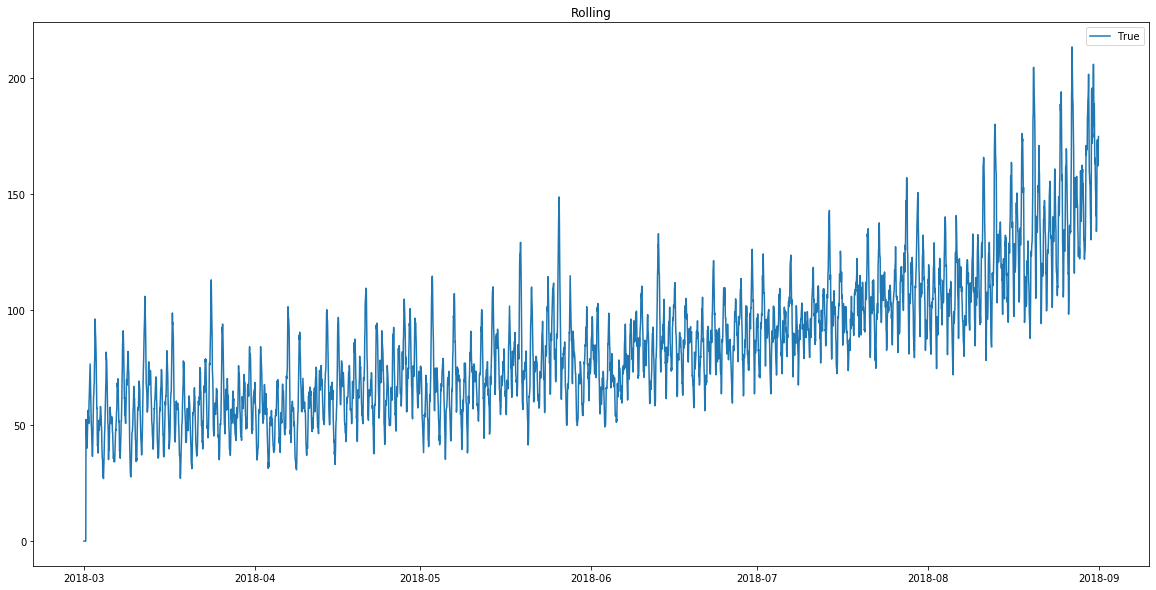

In [16]:
plt.figure(figsize=(20, 10))

plt.plot(data['rolling_mean'], label='True')

plt.title('Rolling')
plt.legend()
plt.show()

In [17]:
train, test = train_test_split(data, shuffle=False, test_size=0.1, random_state=rnd_state)
train = train.dropna()

In [18]:
features_train = train.drop(columns=['num_orders'])
target_train = train['num_orders']

features_test = test.drop(columns=['num_orders'])
target_test = test['num_orders']

<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='red'>
Дальше, ты используешь перебор в цикле, чтобы выбрать модель. Тогда лучше разбить выборку на три: трайн - обучаемся, валидация - проеряем парамтеры модели, тест - окончательная проверка модели.
    
<font color='black'>
- готово

<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА 2 (22/09/2020)</u>
</font>
<font color='red'>
Тут ещё так: в данном случае надо использовать дополнительный параметр shuffle=False , чтобы выборки не перемешивались. т.к. у нас временной ряд. () 
<font color='black'>
- готово

Рассмотрим 5 моделей регрессии и выберем наиболее подходящую для нашей задачи.

#### Линейная регрессия

In [19]:
model = LinearRegression()
model.fit(features_train, target_train)
predict_lr = pd.DataFrame(model.predict(features_train))
mse = mean_squared_error(target_train, predict_lr)
print('RMSE LinearRegression:', mse ** 0.5)

RMSE LinearRegression: 33.02018551120429


#### Модель Случайного Леса

In [20]:
for i in range(1, 21):
    model_random = RandomForestRegressor(n_estimators=i, random_state=rnd_state)
    model_random.fit(features_train, target_train)
    
    predict_random = pd.DataFrame(model_random.predict(features_train))
    rmse_random = mean_squared_error(target_train, predict_random) ** 0.5
    print('n_estimators=', i, ':', rmse_random) 

n_estimators= 1 : 31.585344698338318
n_estimators= 2 : 29.721617268051602
n_estimators= 3 : 29.142895358228557
n_estimators= 4 : 28.877845452140978
n_estimators= 5 : 28.7324068086929
n_estimators= 6 : 28.617517407438047
n_estimators= 7 : 28.490539154919883
n_estimators= 8 : 28.419984368795657
n_estimators= 9 : 28.34252479685424
n_estimators= 10 : 28.320852059636834
n_estimators= 11 : 28.283396470347103
n_estimators= 12 : 28.26671395673882
n_estimators= 13 : 28.272404572361243
n_estimators= 14 : 28.23269002743753
n_estimators= 15 : 28.216626970180048
n_estimators= 16 : 28.183086645500858
n_estimators= 17 : 28.1587055634546
n_estimators= 18 : 28.171283066187783
n_estimators= 19 : 28.150454710755177
n_estimators= 20 : 28.134374177052926


#### LightGBM модель

In [21]:
from collections import defaultdict
d = defaultdict(list)

lgbm_model = LGBMRegressor(num_leaves=31, learning_rate=0.05, n_estimators=20, random_state=rnd_state)
lgbm_model.fit(features_train, target_train)
predict_lgbm = pd.DataFrame(lgbm_model.predict(features_train))
rmse_lgbm = mean_squared_error(target_train, predict_lgbm) ** 0.5

print("RMSE LGBMRegressor:", rmse_lgbm)

RMSE LGBMRegressor: 33.29971410094236


#### CatBoost модель

In [22]:
cat_model = CatBoostRegressor(loss_function="RMSE", iterations=50, random_state=rnd_state)
cat_model.fit(features_train, target_train, verbose=10)

predict_cat = cat_model.predict(features_train)
rmse_cat = mean_squared_error(target_train, predict_cat) ** 0.5

print("RMSE CatBoostRegressor:", rmse_cat)

0:	learn: 38.3665772	total: 49ms	remaining: 2.4s
10:	learn: 36.1010813	total: 210ms	remaining: 746ms
20:	learn: 34.7594707	total: 411ms	remaining: 567ms
30:	learn: 33.9811139	total: 603ms	remaining: 370ms
40:	learn: 33.5183648	total: 793ms	remaining: 174ms
49:	learn: 33.2716735	total: 893ms	remaining: 0us
RMSE CatBoostRegressor: 33.27167349654628


#### Lasso модель

In [23]:
lasso_model = linear_model.Lasso(alpha=0.1)
lasso_model.fit(features_train, target_train)

predict_lasso = lasso_model.predict(features_train)
rmse_lasso = mean_squared_error(target_train, predict_lasso) ** 0.5

print("RMSE Lasso:", rmse_lasso)

RMSE Lasso: 33.02018578519037


<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='red'>
т.к. не используется кросс-валидация, то в данном случае алгортм такой:<br>
обучаем на трайне, а проверяем на валидационной выборке. А потом проверяем на тесте окончательно.<br>
В данной модели нет подбора параметров, тогда сразу можно на тетсет проверять.
    
<font color='black'>
- готово

#### Вывод: 
Исходя из анализа: можно сделать вывод, что модель "Случайного леса" наиболее подходящее. Далее проведем тестирование, чтобы подтвердить наше предположение. 

# 4. Тестирование

In [24]:
model_random = RandomForestRegressor(n_estimators=20, random_state=rnd_state)
model_random.fit(features_test, target_test)
    
predict_random = pd.DataFrame(model_random.predict(features_test))
rmse_random = mean_squared_error(target_test, predict_random) ** 0.5
print(rmse_random) 

32.192372690176164


<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='red'>
Тут обучать лучше на трайне, а вот проверять на тесте. Посмотри, пожалуйста, этот момет ещё раз)
    
<font color='black'>
- готово

Посмотрим дополнительно график предсказаний и реальных значений: 

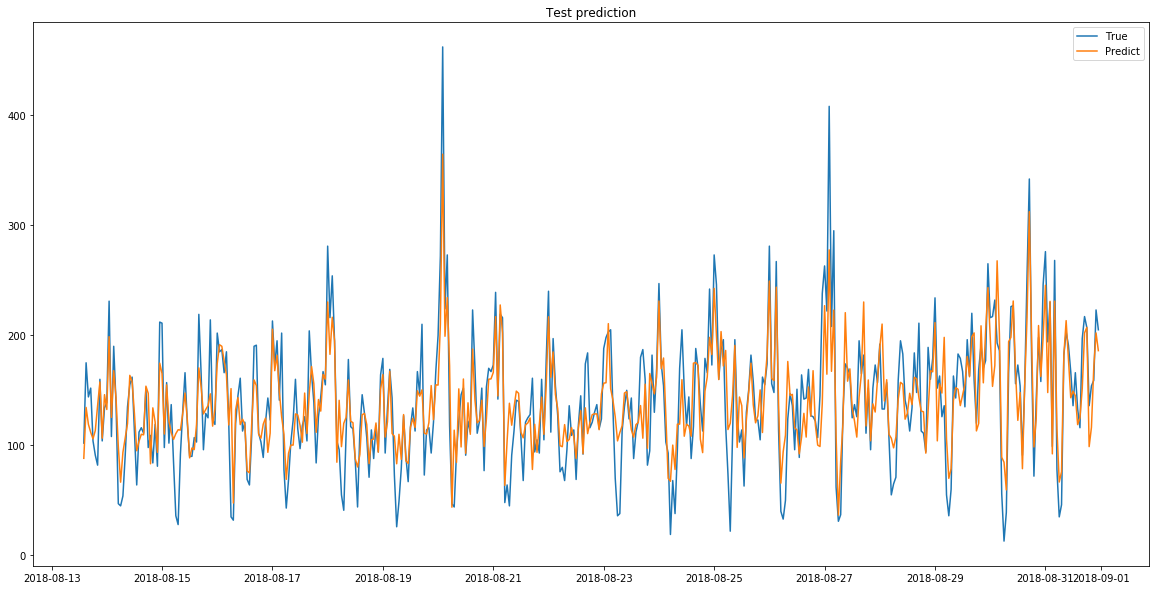

In [25]:
plt.figure(figsize=(20, 10))

plt.plot(target_test, label='True')
plt.plot(target_test.index, predict_random, label='Predict')

plt.title('Test prediction')
plt.legend()
plt.show()

<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'>
отлично) этот инструмент - очень важен при анализе результатов моделирования.<br>
<font color='orange'>
Единственное что - на более коротком (лучше тестовом )периоде его смотреть. Чтобы чётче всё увидеть.<br>

<font color='black'> 
А мы же на тестовом смотрим? или ты имеешь ввиду просто посмотреть на короткий промежуток (например август месяц на target_test?) =) Только график стал странным каким-то) 
    

<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА 2</u>
</font>
<font color='green'>
да уж, график более, чем странный, ты права)<br>
Надо его как-то вылечить (shuffle=False в разбиении на выборки - скорее вего в этом деле)<br>
И верно - лучше удобно смотртеть на тестовом периоде именно!

#### Выводы: 

- Данные ресемплированы по 1 часу
- Проведена генерация признаков
- Были исследованы 5 модели регрессии 
- Наиболее подходящая модель - Модель "Случайного леса" 
- Достигнутое значение метрики RMSE на тестовой выборке: 32, что соответствует запросу задачи (не более 48). 

<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'>
Мария, 5 моделей - это здорово.<br>
Видно, что этот скил уже достаточно сильный у тебя.<br>
    
И если сутейно рассуждать, то временные ряды стоят особняком во всём курсе, я бы сказал. Тут чуть иная модельная философия, на мой взгляд. Имменно поэтому позволял себе оставлять большие комментарии, чтобы как-то раскрыть её особенности.<br>
    
Уверен, что сумев понять главную особенность временных рядов - составляющие ряда и их влияние на прогноз продаж, у тебя появится ещё более уверенный скил и по этой теме.<br>
Оставил свои комментарии и готов буду ответить на твои вопросы!<br>
<font color='red'>    
А пока попрошу тебя чуть скорректировать такие моменты:<br>
1) раскрой, пожалуйста, почему именно такие факторы для моделирования выбраны и именно с такими параметрами. (готов также обсудить их, если будут вопросы). Почему только скользящее среднее фактором. А сезонность? В исследовании ты написала, что она есть. И это верно. Тогда и в факторы для моделирования её надо бы вставлять.<br>
    
2) Оставил комментарии по использованию выборок- посмотри, пожалуйста.<br>
<font color='green'>
Спасибо)<BR>
БУДУ ЖДАТЬ КОММЕНТАРИЕВ

Николай, привет! 
Рада вновь с тобой встретиться! =) 

Я поправила вроде бы твои комментарии. 
Хотела бы у тебя уточнить, в практикуме в теории у нас был урок, где мы создавали признаки, вычитали отстающее значение, а также вычисляли скользящее среднее и добавляли его как признак. Рекомендуешь ли ты это делать в этом проекте?

Вот как пример: 

data_ohe = pd.get_dummies(data, drop_first=True)
target = data_ohe['num_orders']
features = data_ohe.drop('num_orders', axis=1)

train, valid = train_test_split(data, test_size=0.1, shuffle=False, random_state=rnd_state)
valid, test = train_test_split(valid , test_size=0.1, shuffle=False, random_state=rnd_state)

features_train = train.drop(columns=['num_orders'])
target_train = train['num_orders']

features_valid = train.drop(columns=['num_orders'])
target_valid = train['num_orders']

features_test = test.drop(columns=['num_orders'])
target_test = test['num_orders']

В таком случае мы же можем просто делить выборку на тестовую и обучающую? Или все равно проводить либо кросс-валидизацию, либо делить на три выборки, как я и переделала? Мне вот что-то подсказывает, что эту функцию очень даже можно сюда применить)  
Заранее спасибо за ответ! )))

<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА 2 (22/09/2020)</u>
</font>
<font color='green'>
ВЕРНО! об этом и писал тебе в прошлый раз - что нужно вставлять факторы, отвечающие за сезонность. Тема временные ряды особенна именно тем, что для моделирования берутся модели с факторами на основе календаря. Вот эта самоя функция. Поэтому да, надо решение создавать с ней.<br>
В общем виде, модель выглядит так:<br>
Продажи = тренд + сезонность1 + сезонность2 + акция + lag_1(2,3..) + ВНЕШНИЙ ФАКТОР(Температура) + шум<br><br>
    
В нашем случае:<br>
Продажи = тренд + сезонность1 + сезонность2 + lag_1 (2,3..) + шум<br>

Выскажу своё мнение о фактрах этой функции:<br><br>    
1) Фактор год: НЕТ, однозначно не подходит. У нас данных меньше года. Поэтому будет просто константа.<br>
2) Фактор месяц: НЕТ, аналогично году, у нас в истории всего один март, май....<br>
3) Фактор день: НЕТ, также не подходит, будет просто последовательность чисел<br>
4) Фактор день недели: ДА, т.к. у нас есть недельная сезонность<br>
5) Фактор час: ДА, т.к. есть часовая (суточная) сезонность.<br>
6) Факто lag: ДА, это параметр авторегрессии - учёт влияния вчерашних событий на сегодняшние.<br>
7) Фактор rolling: ДА, это аналог тренда. Чем больше окно сглаживания, тем ровнее линия тренда <br>
<font color='red'>    
Попробуй, пожалуйста, построить модель именно с этими факторами.

Николай, привет! 

Ну вроде бы подправила, график предсказаний тоже исправился =) 
Спасибо  тебе за твои размышления! =)

<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА 3 (22/09/2020)</u>
</font>
<font color='green'>
Привет, Кения! Вроде ОК с проектом)<br>
Рад, если мне удалось помочь тебе подразобраться с этой темой.<br>
И тебе спасибо за живой отклик на комментарии)<br>
УСПЕШНОГО ДАЛЬНЕЙШЕГО ОБУЧЕНИЯ!

<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'>
Хотел бы оставить несколько идей для Ваших будущих проектов в этой обоасти<br>

На мой взгляд, в этой теме (временные ряды) главное - необходимо чувствовать исходный ряд продаж, с точки зрения бизнеса, и уже только потом подбирать к нему модели. Каждое колебание временного ряда - это деньги для бизнеса (если говорим что заказчик бизнесовый) и за "трепетами" данных прячутся разные семейства причин. И именно знание их помогут строить хорошие прогнозы..<br>.
Леса, бустинги, регрессии.... могут подобрать хорошие модели на старых данных. Но иногда, как прогноз эти, модели могут оказаться пустышками - не интересными бизнесу. <br>  <br>
Поэтому, от себя позволю добавить несколько идей:<br>
Очень часто ищут "волшебную таблетку" или "кнопку". Нажал и само всё построилось с высокой точностью<br>
Но такого никогода не будет)))<br>
И причиной тому: модели нужно подсказать причины, по которым происходит колебания продаж (временного ряда): понимать причины колебаний треда, понимать аномалии, учитывать акционные продажи, видеть действия конкурентов , закладывать их в модель и т.д. <br><br>
В общем, всё как обычно - три группы факторов: <br>
1)внешние факторы (например выручка такси-компании зависит от количества машин на линии),<br>
2)есть факторы внутри самих данных (Вы использовали как раз поняти лаг, сезонности), <br>
3)есть параметры самих моделей (то, что обычно используется при моделировании леса или деревьев).<br><br>

Ещё важно иметь ввиду горизонт прогноза: на кокой период строить прогноз нужно  - на час вперёд, на неделю, на месяц.<br>
Это также накладывает ограничения на подбор моделей<br>
Я бы рекомендовал Вам составить для себя матрицу  в разрезе: <br>
а)есть тренд/нет тренда; <br>
б)еть сезоннотсь/нет сезонности; <br>
в)какой горизонт прогноза требуется; <br>
г) есть ли у нас дополнительные факторы для модей<br>
На пересечении знаний о моделях легко будет подобрать адкватную модель.
Не все задачи прогнозирования временных рядов можно хорошо решить лесом и еже с ним на основе знаний только факторов ряда... Они хорошо подойдут для коротких горизонтов прогнозирования.... А если горизонт чуть больше: недели, месяцы... то тут надо подключать понимания фаткоров продаж самого бизнеса.

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48